# Informe Tarea 2 Grupo 2
## Nombre Alumnos: Ignacio Brito, José Tomás De la Peña, Ítalo Salazar, Alex Villarroel

## P1 - Programación del Problema Directo
Se provee de una carpeta ajuste_ortogonal_recta que deberá copiar en la carpeta del paquete de python
desarrollado en la Tarea 1, es decir al interior de GF7013/models/. En este módulo se encuentra la definición
de la recta paramétrica y el prototipo de una clase forward que permitirá calcular el modelo directo.
En un intento por generalizar los códigos de muestreo que se utilizan posteriormente, se definirá un requerimiento
que debe cumplir la clase forward (que implementa el modelo directo para cualquier problema y no sólo para el
ajuste ortogonal a la recta): que un objeto que sea instancia de la clase forward debe implementar la función
miembro eval(m) donde m es el vector de parámetros del modelo.
Para el problema del ajuste ortogonal de la linea recta, se tiene m = [a, θ]⊤, donde a es la distancia de la recta
al origen y θ define la orientación de la recta en sentido anti-horario con respecto al eje x (ver apunte que define
el problema de ajuste ortogonal a la recta).
Luego se pide:

### P1.1 Completar la función eval(self, m) de la manera más concisa posible. Para ello utilice el paquete recta que se provee.
-----------------------------------------------------------------------------------------------
La función eval se calculó calcula la predicción de los parámetros del modelo, es decir, dados los valores de las observaciones (incluyendo los sigmas), y los parámetros de modelo, en este caso a y el ángulo $\theta$, retorne los valores de la estimación del problema directo

Este método se implementó de la siguiente manera:

```python
class forward(object):
# 
# definición de la clase ...
# método eval
    def eval(self, m):
        """
        Computes a prediction of the model parameters (see description in this
        module docstring).
        - m = NP.array([a, theta]) with theta in degrees (both float quantities). 
          -> a is the distance between straight line to origin of coordinate system and 
          -> theta is the orientation of the straight line measured counter-clockwise 
            measured from x axis. 
        """
        # Extract model parameters
        a, theta = m[0], m[1]

        # calculate the predicted points in the straight line
        dpred = recta.calc_xy_pred(a, theta, self.x_obs, self.y_obs)

        # dpred incluyendo el cálculo de los sigma

        return dpred


In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))


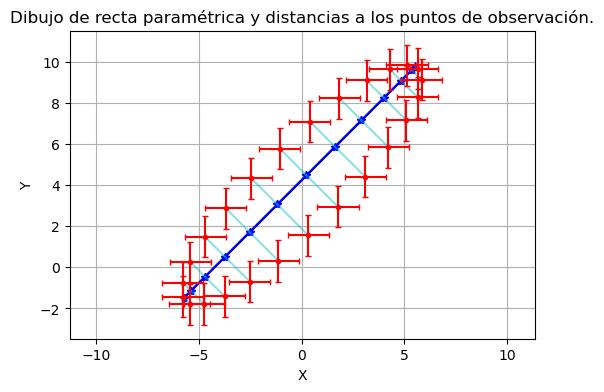

In [3]:
### P1.2 - Ejemplo de modelo directo


from GF7013.models.ajuste_ortogonal_recta.forward import forward
import numpy as np
from GF7013.bin.Tarea2.P1.datos import obtener_datos_elipses
from GF7013.models.ajuste_ortogonal_recta import recta
N = 25
semi_eje_mayor = 8
semi_eje_menor = 2
alpha = 45
delta_x = 0
delta_y = 4
desviacion_estandar_x = 1.0
desviacion_estandar_y = 1.0
# valores de d
x_obs, y_obs, sigma_x, sigma_y = obtener_datos_elipses(
                                        N = N,
                                        a = semi_eje_mayor,
                                        b = semi_eje_menor,
                                        alpha = alpha,
                                        deltax = delta_x,
                                        deltay = delta_y,
                                        sigma_x = desviacion_estandar_x,
                                        sigma_y = desviacion_estandar_y)
# valores de m 
a = 3
theta = 45 # grados sexagesimales despues de hacer P1.1)
# se define m como un array
m = np.array([a, theta]) # modelo de recta a graficar.

directo = forward(x_obs=x_obs, y_obs=y_obs, sigma_x=sigma_x, sigma_y=sigma_y)
# le calculamos las predicciones de la recta
# s es el vector con la proyeccion ortogonal de cada punto en la recta.
# s = np.array([np.array([x_obs[i], y_obs[i]]).dot(t) for i in range(0, len(x_obs))])
x_pred, y_pred, s = directo.eval(m)

# plotear los resultados
import matplotlib.pyplot as plt
fig = plt.figure(1)
fig.clear()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)
# en el comando siguiente, si el color es 'none' no se grafica el elemento.
# recta.plot_recta(ax, *m, x_obs=x_obs, y_obs=y_obs, color_dist='c', color='b')
ax.plot(x_pred, y_pred, 'b-*', label='Recta paramétrica')
ax.plot([x_pred, x_obs],
        [y_pred, y_obs],
        linestyle = '-', 
        color = 'c', 
        alpha = alpha/100)
ax.errorbar(x=x_obs, y=y_obs, xerr=sigma_x, yerr=sigma_y, fmt='.r', capsize=2)
ax.axis('equal')
ax.grid('on')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Dibujo de recta paramétrica y distancias a los puntos de observación.')
fig.canvas.draw()
plt.show()

##  P2. Modelación Inversa usando Métodos Bayesianos: A priori's y función  $f_{prior}(m)$

### P2.1. Densidad volumétrica a priori para los parámetros del modelo fprior(m)
Para la densidad volumétrica a priori de los parámetros del modelo fprior(m), se asumirá el estado homogéneo de información. Para ello, se considera que los parámetros del modelo son ambos parámetros cartesianos, por lo que la fdp a priori para m será la de una distribución uniforme.


Se debe definir un rango de valores posibles para el parámetro a que sea lo suficientemente grande, por ejemplo, ±2 veces el máximo de las normas de $d^{obs}_k$ (que son los datos observados a ajustar con la recta, o los datos sintéticos a usar en esta tarea).

Además, se define el rango de posibles valores de θ en el intervalo $[−180, 180[$ grados sexagesimales.

En la Tarea 1, en GF7013/probability_functions/pdf/pdf_uniform_nD.py programaron una
clase pdf_uniform_nD, que permite calcular la verosimilitud (i.e., sin normalizar) - y su logaritmo natural - de una distribución uniforme de n dimensiones.

En la carpeta Tarea2/tests escriba un script test_fprior.py que cree una instancia de pdf_-
uniform_nD que represente fprior (m) para el caso del problema del ajuste a la recta y genere 1E5 muestras de fprior(m). Graficar el histograma conjunto de (a, θ) – use matplotlib.pyplot.hist2d – y los histogramas marginales para cada uno de los dos parámetros. Recuerde escoger bien el número o tamaño de casilleros del histograma para que luzca como una distribución uniforme.

----------------------------------Resolución -------------------------------------------------------

Para la resolución del problema, en la función test_fprior se definió la función histogram_p2_1 que realiza el histograma 2d solicitado con sus respectivos histogramas marginales para cada parámetro. 

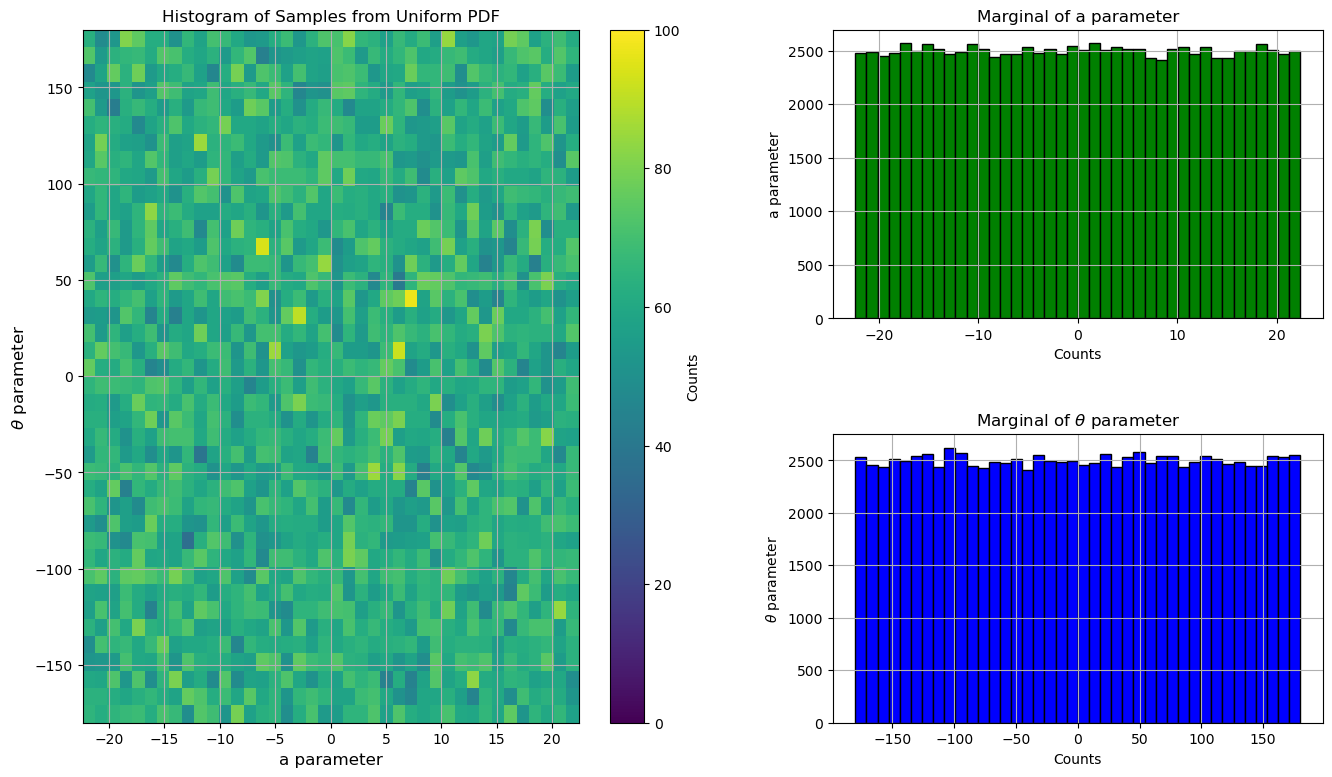

In [6]:
from GF7013.probability_functions.pdf import pdf_uniform_nD
norm_dobs = np.sqrt((x_obs**2+y_obs**2))
#
ll_a, ul_a = -2*np.max(norm_dobs), 2* np.max(norm_dobs)
ll_theta, ul_theta = -180,180 
#
lower_lim = np.array([ll_a,ll_theta])
upper_lim = np.array([ul_a,ul_theta])
par = {'lower_lim': lower_lim,'upper_lim':upper_lim}
pdf_uniforme = pdf_uniform_nD(par)
#
N_samples = 1e5
#
LogOfZero = None
rng = np.random.default_rng(42)  # Para reproducibilidad
f_prior = pdf_uniform_nD(par, LogOfZero=LogOfZero, rng=rng) 
samples = f_prior._draw(N_samples)
# Ahora llamamos a la función para plotear que se creó en test_fprior.py
# podríamos agregarla a utils
import GF7013.bin.Tarea2.tests.test_fprior as test_fprior
fig = test_fprior.histogram_p2_1(samples,0,100);
plt.show();


### P2.2 Función de Verosimilitud $\mathcal{L}(m)$

Para poder definir la función de verosimilitud de un modelo $\mathcal{L}(m)$ primero se definirá la distribución a priori
para la variable de interés. En este caso, como se desea hacer un ajuste ortogonal de una recta, se quiere encontrar
modelos que minimicen la distancia a los datos. Luego, la variable sobre la cual se debe definir información a priori
corresponde a la distancias $\Delta_k$ entre los pares ordenados observados y la recta (ver archivo pdf adjunto con la tarea y explicado por el profesor auxiliar).

En esta tarea se asume que los errores de dichas distancias son independientes y que siguen una distribución normal. Como se quiere que dichas distancias sean lo más pequeñas posibles, se propone utilizar una distribución
normal, con media nula y varianzas $\sigma^2_{\Delta_k}$ con fdp:

$$ \rho_\Delta(\mathbf{\Delta,\sigma^2_{\Delta_k}}) =  \nu e ^{-\frac{1}{2}\sum_{k=1}^N \frac{\Delta^2_k}{\sigma^2_{\Delta_k}}}  $$

Donde $\nu$ es una constante de normalización.

Luego, si para un modelo $\mathbf{m}$ dado, se calcula las distancias $\mathbf{\Delta(m)}$ y la bariaza de dichas distancias $\mathbf{\sigma^2_\Delta(m)}$, la verosimilitud de dicho modelo se puede calcular como:

$$𝓛(\mathbf{m}) = \rho_\Delta(\mathbf{\Delta(m),\sigma^2_{\Delta}(m)}) $$

La función de verosimilitud se encuentra programada en GF7013/probability_functions/likelihood_function.py. Esta recibe una instancia de modelo directo (forward) y una instancia de la fdp a priori de los datos (pdf_data). Se recomienda leer el código de la función de verosimilitud antes de proseguir con el desarrollo
de la tarea.

## P2.2.1 Verificación de la programación de $\rho_\Delta$

La función de probabilidad a priori para las observaciones se asumirá como una distribución Normal Multivariada. En la Tarea 1, se programó la clase pdf_normal.py en el módulo GF7013/probability_functions/pdf_normal.py. En esta parte de la tarea debe cerciorarse de que dicha clase funcione, y es una oportunidad para arreglar cualquier error que haya tenido en el desarrollo de la Tarea 1.

Para verificar su programación de pdf_normal.py, cree un script en el módulo Tarea2/tests/test_pdf_normal.py que genera 100.000 muestras de una distribución normal multivariada con media mu = np.array([-1, 4]) y matriz de covarianza cov = NP.array([[2, 1], [1, 4]]) y que luego verifique que el promedio y matriz de covarianza calculados con las muestras sea similar a mu y cov anteriores, respectivamente.

Además, se pide hacer un histograma 2D de las muestras de la fdp conjunta y hacer histogramas de las 2 fdp marginales.

Sample Mean: [-1.00312805  3.99973846]
Sample Covariance:
 [[1.99495575 0.99220652]
 [0.99220652 4.0409389 ]]


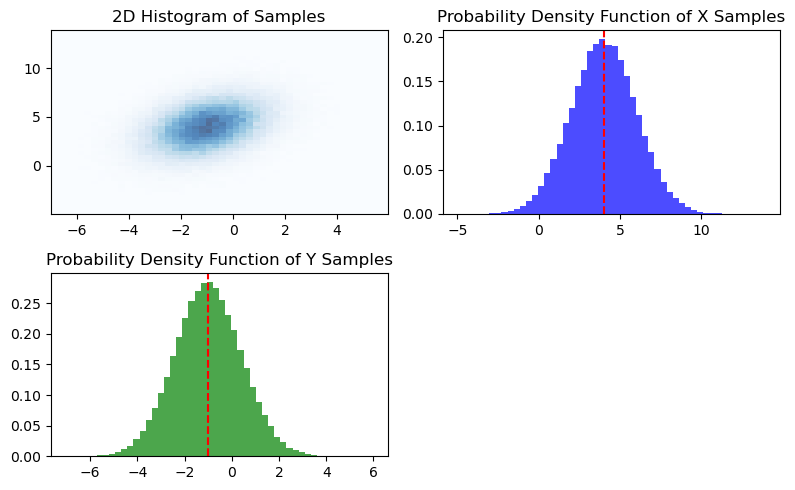

In [7]:
from GF7013.probability_functions.pdf import pdf_normal

N_samples = 1e5
mu = np.array([-1, 4])
cov = np.array([[2, 1], [1, 4]])
rng = np.random.default_rng(42)  # Para reproducibilidad
par = {'mu': mu, 'cov': cov}

f_prior = pdf_normal(par, rng=rng)
samples = f_prior._draw(N_samples)

# Verificar covarianza y media de las muestras
sample_mean = np.mean(samples, axis=1)
sample_cov = np.cov(samples)
print("Sample Mean:", sample_mean)
print("Sample Covariance:\n", sample_cov)

# Graficar las muestras
fig, ax = plt.subplots(2, 2, figsize=(8, 5))
ax[0, 0].hist2d(samples[0], samples[1], bins=50, density=True, cmap='Blues', alpha=0.7)
ax[0, 0].set_title('2D Histogram of Samples')
ax[0, 1].hist(samples[1], bins=50, density=True, alpha=0.7, color='blue')
ax[0, 1].axvline(mu[1], color='red', linestyle='--', label='Mean')
ax[0, 1].set_title('Probability Density Function of X Samples')
ax[1, 0].hist(samples[0], bins=50, density=True, alpha=0.7, color='green')
ax[1, 0].axvline(mu[0], color='red', linestyle='--', label='Mean')
ax[1, 0].set_title('Probability Density Function of Y Samples')
fig.delaxes(ax[1, 1])
plt.tight_layout()
plt.show()

### P2.2.2. Verificación de la programación de L(m)
Para verificar la programación de L(m), se utilizará el método de Grid-Search para resolver el problema inverso (ver apuntes del curso GF5013), esto se puede hacer ya que solo hay dos parámetros involucrados. Para ello, use los datos sintéticos que se proveen en GF7013/bin/Tarea2/P1/P1b.py y cree un script en el módulo
Tarea2/tests/test_Likelihood.py.
En dicho script,

1. Defina un conjunto de valores de a y θ (use np.linspace) que cubran el rango de valores con probabilidad
no nula de $f_{prior}(m)$. Luego, cree un conjunto de modelos m con todas las combinaciones posibles de a y
θ.
2. Cree una instancia de la clase ensemble, que se encuentra definida en GF7013/model_parameters/
ensemble.py, guarde ahí el conjunto de modelos y llene las variables fprior, like, y f con las verosimilitudes
correspondientes a cada uno de esos modelos (i.e., use la función likelihood de los objetos definidos para
$f_{prior}(m)$  y $\mathcal{L}(m)$)
3. Cree otra instancia de la clase ensemble, que se encuentra definida en GF7013/model_parameters/
ensemble.py, guarde ahí el conjunto de modelos y llene las variables fprior, like, y f con el logaritmo
natural de las verosimilitudes correspondientes a cada uno de esos modelos (i.e., use la función log_likelihood de los objetos definidos para $f_{prior}(m)$  y $\mathcal{L}(m)$)

4. Haga un gráfico 2D con colores (puede usar matplotlib.pyplot.pcolor o matplotlib.pyplot.scatter, en el segundo teniendo cuidado con el tamaño de los símbolos) para los valores de verosimilitud fprior, like, y f; y del logaritmo natural de la verosimilitud fprior, like, y f (son 6 gráficos de colores en total)

#### Resolución
1- Definir todas las combinaciones de valores de a y de $\theta$ es posible realizando un mallado 2d con np.meshgrid(), y luego uniendo ambos parametros aplanando cada componente del mallado. Los limites de a fueron definidos en el enunciado como $\pm 2 \cdot max(|d_{k}^{obs}|)$, mientra que $\theta$ de -180 a 180 grados hexadecimales



[ -37.01978056 -180.        ]
[ -36.27190621 -180.        ]
[ -35.52403185 -180.        ]
[ -34.7761575 -180.       ]
[ -34.02828314 -180.        ]
[ -33.28040879 -180.        ]
[ -32.53253443 -180.        ]
[ -31.78466008 -180.        ]
[ -31.03678572 -180.        ]
[ -30.28891137 -180.        ]
[ -29.54103701 -180.        ]
[ -28.79316266 -180.        ]
[ -28.0452883 -180.       ]
[ -27.29741395 -180.        ]
[ -26.54953959 -180.        ]
[ -25.80166524 -180.        ]
[ -25.05379089 -180.        ]
[ -24.30591653 -180.        ]
[ -23.55804218 -180.        ]
[ -22.81016782 -180.        ]
[ -22.06229347 -180.        ]
[ -21.31441911 -180.        ]
[ -20.56654476 -180.        ]
[ -19.8186704 -180.       ]
[ -19.07079605 -180.        ]
[ -18.32292169 -180.        ]
[ -17.57504734 -180.        ]
[ -16.82717298 -180.        ]
[ -16.07929863 -180.        ]
[ -15.33142427 -180.        ]
[ -14.58354992 -180.        ]
[ -13.83567556 -180.        ]
[ -13.08780121 -180.        ]
[ -12.33992685 -

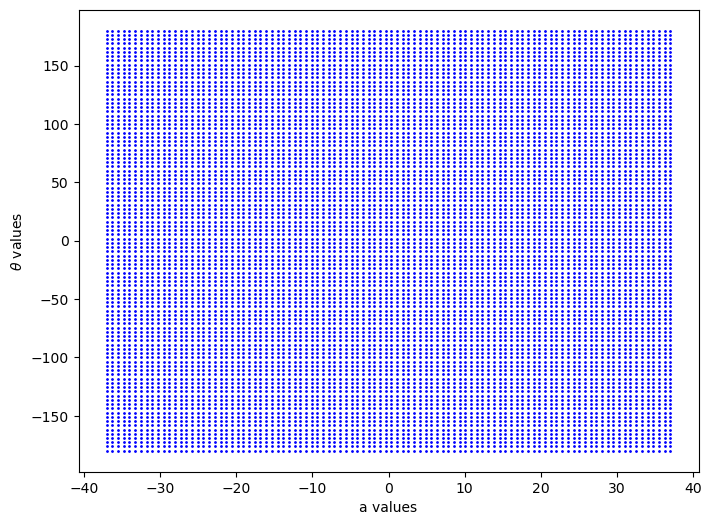

In [25]:
from GF7013.bin.Tarea2.P1.datos import obtener_datos_elipses
from GF7013.model_parameters.ensemble import ensemble
from GF7013.probability_functions.pdf import pdf_uniform_nD,pdf_normal
from GF7013.probability_functions.likelihood.likelihood_function import likelihood_function
from GF7013.models.ajuste_ortogonal_recta.forward import forward
from GF7013.models.ajuste_ortogonal_recta.recta import calc_dist_sigma
# Generar datos sinteticos
N = int(70)
semi_eje_mayor = 10
semi_eje_menor = 2
alpha = -45
delta_x = 0
delta_y = -10
desviacion_estandar_x = 1.0
desviacion_estandar_y = 0.5

x_obs, y_obs, sigma_x, sigma_y = obtener_datos_elipses(
                                        N = N,
                                        a = semi_eje_mayor,
                                        b = semi_eje_menor,
                                        alpha = alpha,
                                        deltax = delta_x,
                                        deltay = delta_y,
                                        sigma_x = desviacion_estandar_x,
                                        sigma_y = desviacion_estandar_y)

# definición de los parámetros
norm_dobs = np.sqrt((x_obs**2+y_obs**2))
#
ll_a, ul_a = -2*np.max(norm_dobs), 2* np.max(norm_dobs)
ll_theta, ul_theta = -180,180 
#
lower_lim = np.array([ll_a,ll_theta])
upper_lim = np.array([ul_a,ul_theta])

# Valores de la grilla

theta_values = np.linspace(ll_theta, ul_theta, 100)
a_values = np.linspace(ll_a, ul_a, 100)

Nmodels = len(theta_values) * len(a_values)
Npar=2

a_grid,theta_grid = np.meshgrid(a_values,theta_values)
m_values = np.column_stack([a_grid.ravel(),theta_grid.ravel()])
# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(a_grid, theta_grid, s=1, color='blue')
ax.set_xlabel('a values')
ax.set_ylabel(r'$\theta$ values')
for i,m in enumerate(m_values):
    print(m)

2 y 3- 

In [ ]:
par = {'lower_lim': lower_lim, 'upper_lim': upper_lim}
LogOfZero = None
rng_uni = np.random.default_rng(66)
f_prior = pdf_uniform_nD(par=par, LogOfZero=LogOfZero, rng=rng_uni)

# Forward model
forward_model = forward(x_obs, y_obs, sigma_x, sigma_y)

# Likelihood function
LogOfZero = None
rng = np.random.default_rng(777)

likelihood=np.zeros(Nmodels)
likelihood_f_prior=np.zeros(Nmodels)
likelihood_f_posterior= np.zeros(Nmodels)

# Log likelihood
loglikelihood = np.zeros(Nmodels)
loglikelihood_f_prior = np.zeros(Nmodels)
loglikelihood_f_posterior = np.zeros(Nmodels)

mu = np.zeros(N)
cov = np.eye(N)

par = {'mu': mu, 'cov': cov}
likelihood_func = likelihood_function(forward_model, pdf_normal(par=par, rng=rng))

for i, model in enumerate(m_values):
    likelihood_f_prior[i] = f_prior._likelihood(model)
    likelihood[i] = likelihood_func.likelihood(model)
    likelihood_f_posterior[i] = likelihood_f_prior[i] * likelihood[i]
    
    # Log likelihood
    loglikelihood_f_prior[i] = f_prior._log_likelihood(model)
    loglikelihood[i] = likelihood_func.log_likelihood(model.tolist())
    loglikelihood_f_posterior[i] = loglikelihood_f_prior[i] + loglikelihood[i]

# Create ensemble objects
ensamble = ensemble(Npar = Npar, Nmodels = Nmodels, use_log_likelihood=False)

ensamble.fprior = likelihood_f_prior
ensamble.like = likelihood
ensamble.f = likelihood_f_posterior

ensamble_log = ensemble(Npar=Npar,Nmodels=Nmodels,use_log_likelihood=True)

ensamble_log.fprior = loglikelihood_f_prior
ensamble_log.like = loglikelihood
ensamble_log.f = loglikelihood_f_posterior

Floating point overflow when calculating the normalization constant.
Use log_pdf or (log) Likelihood values instead of pdf.


AttributeError: 'tuple' object has no attribute 'ndim'